In [3]:
# 0) Kütüphaneler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("kainatjamil12/housing")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'housing' dataset.
Path to dataset files: /kaggle/input/housing


In [6]:
# Dataset yükle
df = pd.read_csv("/kaggle/input/housing/Housing.csv")

print("=" * 60)
print("KONUT FİYAT TAHMİN MODELİ ")
print("=" * 60)
df.head()
print(df.info())
print(df.describe(include='all'))

# Check for missing values
missing_values = df.isnull().sum()
print('Missing values:')
print(missing_values)

KONUT FİYAT TAHMİN MODELİ 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None
               price          area    bedrooms   bathrooms     stories  \
count   5.450000e+02    545.000000  545.000000  

In [7]:
df.describe(include = object) # Summary for categorical features

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
count,545,545,545,545,545,545,545
unique,2,2,2,2,2,2,3
top,yes,no,no,no,no,no,semi-furnished
freq,468,448,354,520,373,417,227


In [8]:
# VERİ ÖNİŞLEME
# 1. Binary kolonları encode et
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
               'airconditioning', 'prefarea']
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# 2. Furnishing status için one-hot encoding
df = pd.get_dummies(df, columns=['furnishingstatus'], prefix='furn', drop_first=True)

# 3. Feature Engineering - Yeni özellikler oluştur
df['total_rooms'] = df['bedrooms'] + df['guestroom']
df['bath_per_bedroom'] = df['bathrooms'] / (df['bedrooms'] + 1)  # +1 sıfıra bölmeyi önler
df['area_per_room'] = df['area'] / (df['total_rooms'] + 1)
df['parking_area_ratio'] = df['parking'] / (df['area'] / 1000)
df['luxury_score'] = (df['airconditioning'] + df['basement'] +
                      df['hotwaterheating'] + df['prefarea'])
df['location_quality'] = df['mainroad'] * 2 + df['prefarea']

In [9]:
# 4. Özellik seçimi
feature_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking',
                'mainroad', 'guestroom', 'basement', 'hotwaterheating',
                'airconditioning', 'prefarea', 'total_rooms', 'bath_per_bedroom',
                'area_per_room', 'parking_area_ratio', 'luxury_score',
                'location_quality', 'furn_semi-furnished', 'furn_unfurnished']

X = df[feature_cols]
y = df['price']

In [10]:

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 6. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Veri Boyutları:")
print(f"   Train: {X_train.shape}, Test: {X_test.shape}")
print(f"   Özellik sayısı: {X_train.shape[1]}")




 Veri Boyutları:
   Train: (436, 19), Test: (109, 19)
   Özellik sayısı: 19


In [12]:
#MODEL EĞİTİMİ

models = {}

# Model 1: Random Forest (optimize edilmiş)
print("\n Random Forest eğitiliyor...")
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_model

# Model 2: Gradient Boosting
print(" Gradient Boosting eğitiliyor...")
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
models['Gradient Boosting'] = gb_model

# Model 3: Ridge Regression (log-transform ile)
print(" Ridge Regression eğitiliyor...")
y_train_log = np.log1p(y_train)
ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train_scaled, y_train_log)
models['Ridge (log)'] = ridge_model
print(" Tamamlandı")


 Random Forest eğitiliyor...
 Gradient Boosting eğitiliyor...
 Ridge Regression eğitiliyor...
 Tamamlandı


In [13]:
#MODEL DEĞERLENDİRME

print("\n" + "=" * 60)
print("MODEL PERFORMANS KARŞILAŞTIRMASI")
print("=" * 60)

results = []

for name, model in models.items():
    if name == 'Ridge (log)':
        y_pred_log = model.predict(X_test_scaled)
        y_pred = np.expm1(y_pred_log)
    else:
        y_pred = model.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    })

    print(f"\n{name}:")
    print(f"  RMSE: {rmse:,.0f} ")
    print(f"  MAE:  {mae:,.0f} ")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

# En iyi modeli seç
results_df = pd.DataFrame(results)
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"\n EN İYİ MODEL: {best_model_name}")


MODEL PERFORMANS KARŞILAŞTIRMASI

Random Forest:
  RMSE: 1,351,787 
  MAE:  993,442 
  R²:   0.6385
  MAPE: 20.96%

Gradient Boosting:
  RMSE: 1,397,405 
  MAE:  1,006,974 
  R²:   0.6137
  MAPE: 20.92%

Ridge (log):
  RMSE: 1,318,830 
  MAE:  957,152 
  R²:   0.6559
  MAPE: 20.35%

 EN İYİ MODEL: Ridge (log)


In [24]:
#  ÖRNEK TAHMİNLER
print("ÖRNEK TAHMİNLER (İlk 10 Test Verisi)")
print("=" * 60)

pd.options.display.float_format = '{:,.0f}'.format  # sayıları 1.234.567 formatında gösterir

comparison = pd.DataFrame({
    'Gerçek Fiyat': y_test.values[:10],
    'Tahmin': predictions[:10],
})

comparison['Fark'] = (comparison['Gerçek Fiyat'] - comparison['Tahmin']).abs()
comparison['Hata %'] = (comparison['Fark'] / comparison['Gerçek Fiyat'] * 100)


print(comparison.to_string(index=False, formatters={
    'Gerçek Fiyat': '{:,.0f}'.format,
    'Tahmin': '{:,.0f}'.format,
    'Fark': '{:,.0f}'.format,
    'Hata %': '{:.2f}%'.format
}))


ÖRNEK TAHMİNLER (İlk 10 Test Verisi)
Gerçek Fiyat    Tahmin      Fark Hata %
   4,060,000 4,507,786   447,786 11.03%
   6,650,000 7,095,455   445,455  6.70%
   3,710,000 3,304,879   405,121 10.92%
   6,440,000 4,486,254 1,953,746 30.34%
   2,800,000 3,353,341   553,341 19.76%
   4,900,000 3,437,790 1,462,210 29.84%
   5,250,000 5,237,030    12,970  0.25%
   4,543,000 6,257,884 1,714,884 37.75%
   2,450,000 2,799,495   349,495 14.27%
   3,353,000 2,820,606   532,394 15.88%


In [26]:
# ============================================================
# MODEL PERFORMANS KARŞILAŞTIRMASI
# ============================================================

print("\n" + "=" * 60)
print("MODEL PERFORMANS KARŞILAŞTIRMASI")
print("=" * 60)

results = []
predictions_dict = {}  # Ensemble için gerekli

for name, model in models.items():

    # Ridge log modeli için dönüşüm
    if name == 'Ridge (log)':
        y_pred_log = model.predict(X_test_scaled)
        y_pred = np.expm1(y_pred_log)
    else:
        y_pred = model.predict(X_test_scaled)

    # Ensemble için sakla
    predictions_dict[name] = y_pred

    # Metrix hesapla
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    })

    print(f"\n{name}:")
    print(f"  RMSE: {rmse:,.0f}")
    print(f"  MAE:  {mae:,.0f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

# Tablo olarak sonuçlar
results_df = pd.DataFrame(results)
print("\n\n--- MODEL KARŞILAŞTIRMA TABLOSU ---")
print(results_df.to_string(index=False))

# ============================================================
# ENSEMBLE MODEL (3 MODEL ORTALAMASI)
# ============================================================

print("\n" + "=" * 60)
print("ENSEMBLE MODEL (3 MODEL ORTALAMASI)")
print("=" * 60)

# Ortalama tahmin
ensemble_pred = (
    predictions_dict['Random Forest'] +
    predictions_dict['Gradient Boosting'] +
    predictions_dict['Ridge (log)']
) / 3

# Ensemble performansı
rmse_e = np.sqrt(mean_squared_error(y_test, ensemble_pred))
mae_e = mean_absolute_error(y_test, ensemble_pred)
r2_e = r2_score(y_test, ensemble_pred)
mape_e = np.mean(np.abs((y_test - ensemble_pred) / y_test)) * 100

print(f" RMSE: {rmse_e:,.0f}")
print(f" MAE:  {mae_e:,.0f}")
print(f" R²:   {r2_e:.4f}")
print(f" MAPE: {mape_e:.2f}%")


MODEL PERFORMANS KARŞILAŞTIRMASI

Random Forest:
  RMSE: 1,351,787
  MAE:  993,442
  R²:   0.6385
  MAPE: 20.96%

Gradient Boosting:
  RMSE: 1,397,405
  MAE:  1,006,974
  R²:   0.6137
  MAPE: 20.92%

Ridge (log):
  RMSE: 1,318,830
  MAE:  957,152
  R²:   0.6559
  MAPE: 20.35%


--- MODEL KARŞILAŞTIRMA TABLOSU ---
            Model      RMSE       MAE  R²  MAPE
    Random Forest 1,351,787   993,442   1    21
Gradient Boosting 1,397,405 1,006,974   1    21
      Ridge (log) 1,318,830   957,152   1    20

ENSEMBLE MODEL (3 MODEL ORTALAMASI)
 RMSE: 1,316,937
 MAE:  953,831
 R²:   0.6569
 MAPE: 20.18%


In [27]:
# ============================================================
# ÖRNEK TAHMİNLER (ENSEMBLE MODEL – İlk 10 Test Verisi)
# ============================================================

print("\nÖRNEK TAHMİNLER (Ensemble Model - İlk 10 Test Verisi)")
print("=" * 60)

pd.options.display.float_format = '{:,.0f}'.format  # Türkçe format: 1.234.567

# Ensemble tahmin (önceden hesapladığımız)
ensemble_predictions = ensemble_pred

comparison = pd.DataFrame({
    'Gerçek Fiyat': y_test.values[:10],
    'Tahmin (Ensemble)': ensemble_predictions[:10],
})

# Hata hesapları
comparison['Fark'] = (comparison['Gerçek Fiyat'] - comparison['Tahmin (Ensemble)']).abs()
comparison['Hata %'] = (comparison['Fark'] / comparison['Gerçek Fiyat'] * 100)

# Formatlı yazdır
print(comparison.to_string(index=False, formatters={
    'Gerçek Fiyat': '{:,.0f}'.format,
    'Tahmin (Ensemble)': '{:,.0f}'.format,
    'Fark': '{:,.0f}'.format,
    'Hata %': '{:.2f}%'.format
}))



ÖRNEK TAHMİNLER (Ensemble Model - İlk 10 Test Verisi)
Gerçek Fiyat Tahmin (Ensemble)      Fark Hata %
   4,060,000         4,794,287   734,287 18.09%
   6,650,000         6,994,946   344,946  5.19%
   3,710,000         3,616,994    93,006  2.51%
   6,440,000         4,563,730 1,876,270 29.13%
   2,800,000         3,739,998   939,998 33.57%
   4,900,000         3,586,298 1,313,702 26.81%
   5,250,000         5,019,683   230,317  4.39%
   4,543,000         5,730,277 1,187,277 26.13%
   2,450,000         2,920,778   470,778 19.22%
   3,353,000         3,018,289   334,711  9.98%



 Görselleştirmeler 'housing_price_analysis.png' olarak kaydedildi!


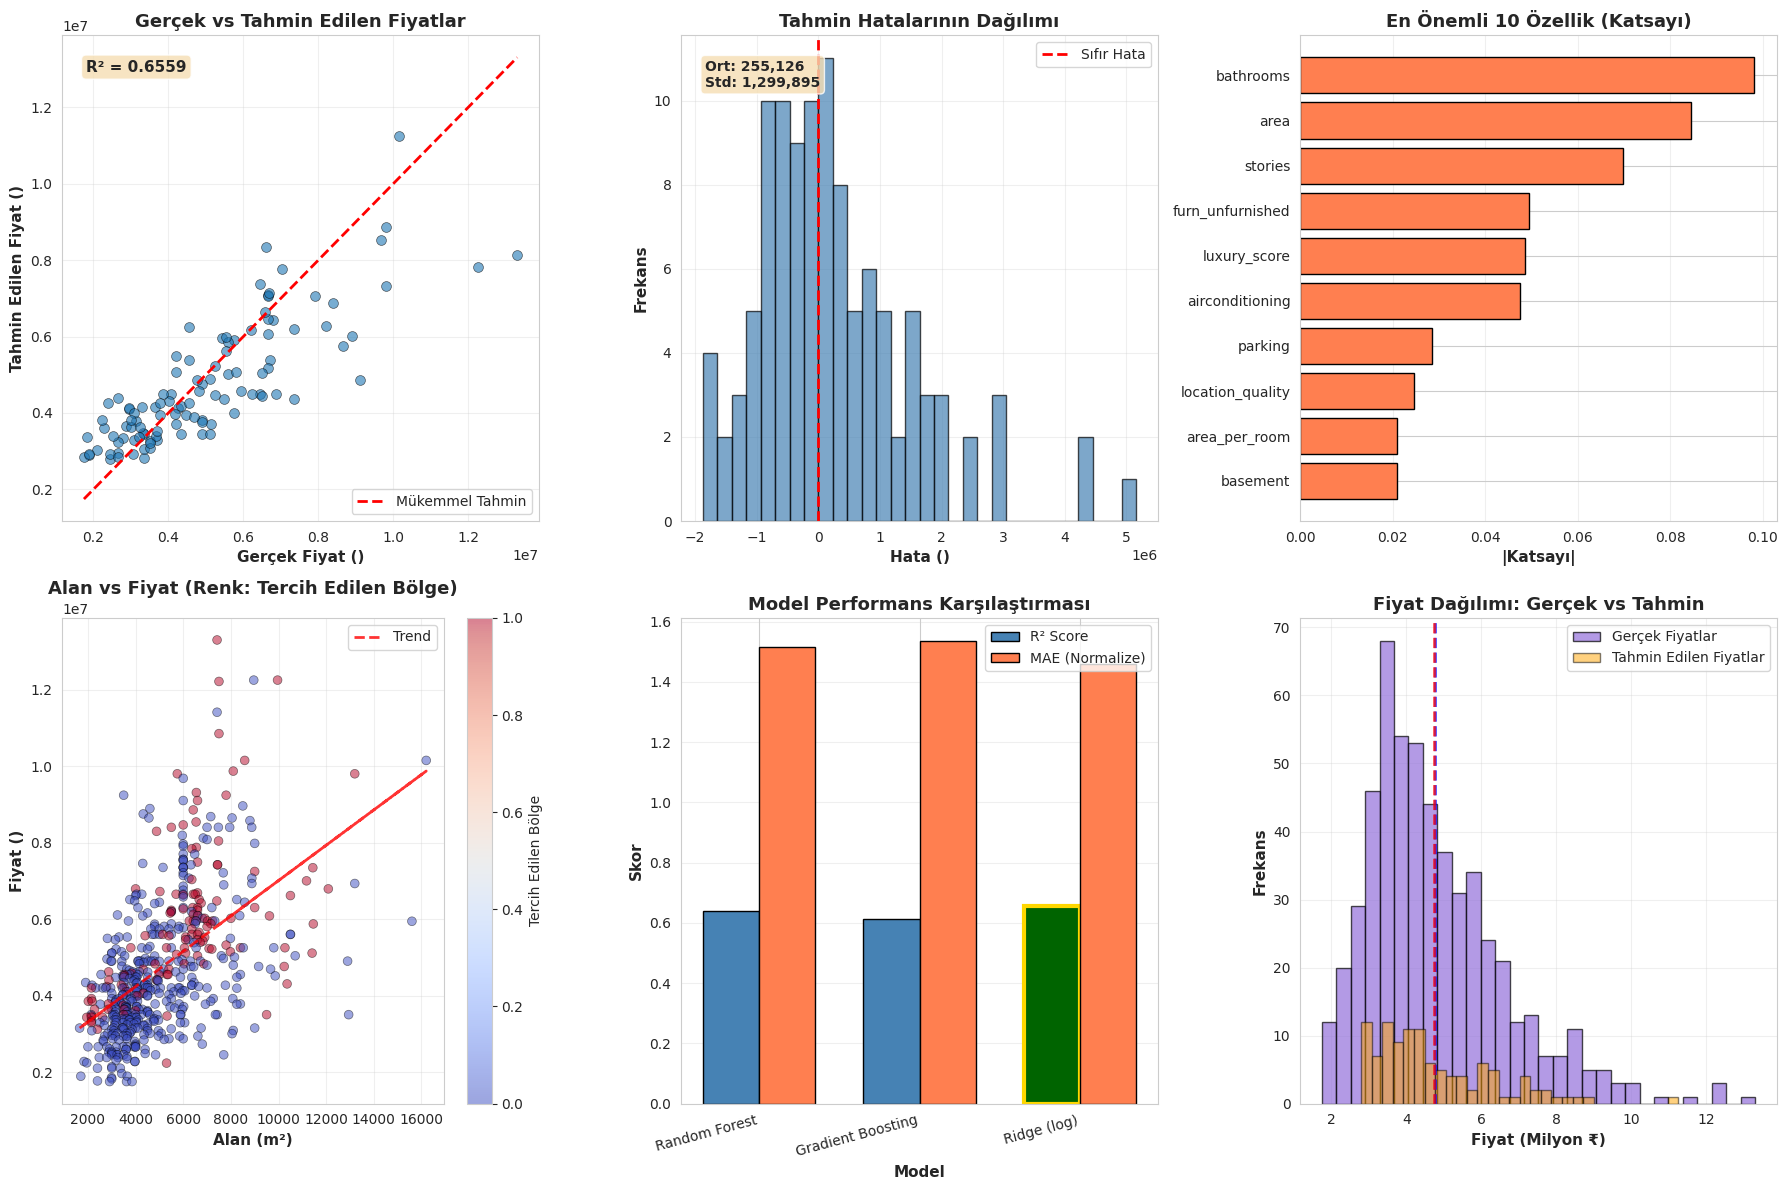

 Korelasyon matrisi 'correlation_matrix.png' olarak kaydedildi!


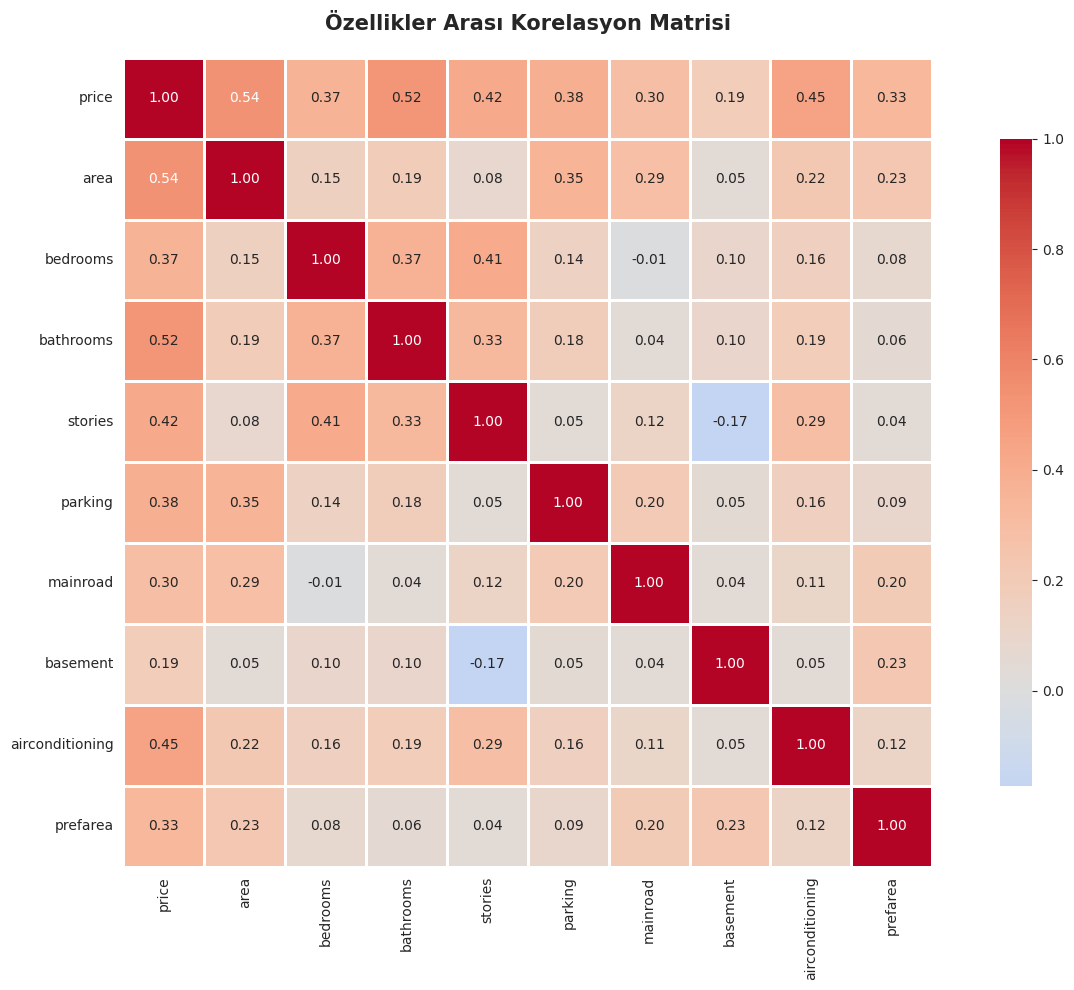


 GÖRSELLEŞTİRME TAMAMLANDI


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Stil ayarları
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

# 6 panelli görselleştirme
fig = plt.figure(figsize=(18, 12))

# ==================== 1. GERÇEK vs TAHMİN ====================
ax1 = plt.subplot(2, 3, 1)
if best_model_name == 'Ridge (log)':
    predictions = np.expm1(best_model.predict(X_test_scaled))
else:
    predictions = best_model.predict(X_test_scaled)

plt.scatter(y_test, predictions, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Mükemmel Tahmin')
plt.xlabel('Gerçek Fiyat ()', fontsize=11, fontweight='bold')
plt.ylabel('Tahmin Edilen Fiyat ()', fontsize=11, fontweight='bold')
plt.title('Gerçek vs Tahmin Edilen Fiyatlar', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# R² değerini göster
r2 = r2_score(y_test, predictions)
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax1.transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top', fontsize=11, fontweight='bold')

# ==================== 2. HATA DAĞILIMI ====================
ax2 = plt.subplot(2, 3, 2)
errors = y_test - predictions
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Sıfır Hata')
plt.xlabel('Hata ()', fontsize=11, fontweight='bold')
plt.ylabel('Frekans', fontsize=11, fontweight='bold')
plt.title('Tahmin Hatalarının Dağılımı', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# İstatistikleri göster
mean_error = errors.mean()
std_error = errors.std()
plt.text(0.05, 0.95, f'Ort: {mean_error:,.0f}\nStd: {std_error:,.0f}',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top', fontsize=10, fontweight='bold')

# ==================== 3. ÖZELLİK ÖNEMİ ====================
ax3 = plt.subplot(2, 3, 3)
if best_model_name != 'Ridge (log)':
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(10)

    plt.barh(range(len(feature_importance)), feature_importance['importance'],
             color='coral', edgecolor='black')
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Önem', fontsize=11, fontweight='bold')
    plt.title('En Önemli 10 Özellik', fontsize=13, fontweight='bold')
    plt.grid(alpha=0.3, axis='x')
else:
    # Ridge için katsayıları göster
    coef_df = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': np.abs(ridge_model.coef_)
    }).sort_values('coefficient', ascending=True).tail(10)

    plt.barh(range(len(coef_df)), coef_df['coefficient'],
             color='coral', edgecolor='black')
    plt.yticks(range(len(coef_df)), coef_df['feature'])
    plt.xlabel('|Katsayı|', fontsize=11, fontweight='bold')
    plt.title('En Önemli 10 Özellik (Katsayı)', fontsize=13, fontweight='bold')
    plt.grid(alpha=0.3, axis='x')

# ==================== 4. ALAN vs FİYAT ====================
ax4 = plt.subplot(2, 3, 4)
plt.scatter(df['area'], df['price'], alpha=0.5, s=40, c=df['prefarea'],
            cmap='coolwarm', edgecolors='black', linewidth=0.5)
plt.xlabel('Alan (m²)', fontsize=11, fontweight='bold')
plt.ylabel('Fiyat ()', fontsize=11, fontweight='bold')
plt.title('Alan vs Fiyat (Renk: Tercih Edilen Bölge)', fontsize=13, fontweight='bold')
plt.colorbar(label='Tercih Edilen Bölge')
plt.grid(alpha=0.3)

# Trendline ekle
z = np.polyfit(df['area'], df['price'], 1)
p = np.poly1d(z)
plt.plot(df['area'], p(df['area']), "r--", linewidth=2, alpha=0.8, label='Trend')
plt.legend()

# ==================== 5. MODEL KARŞILAŞTIRMA ====================
ax5 = plt.subplot(2, 3, 5)
model_names = [r['Model'] for r in results]
r2_scores = [r['R²'] for r in results]
mae_scores = [r['MAE'] / 1000000 for r in results]  # Milyona çevir

x = np.arange(len(model_names))
width = 0.35

bars1 = plt.bar(x - width/2, r2_scores, width, label='R² Score',
                color='steelblue', edgecolor='black')
bars2 = plt.bar(x + width/2, [s/max(r2_scores) for s in mae_scores], width,
                label='MAE (Normalize)', color='coral', edgecolor='black')

plt.xlabel('Model', fontsize=11, fontweight='bold')
plt.ylabel('Skor', fontsize=11, fontweight='bold')
plt.title('Model Performans Karşılaştırması', fontsize=13, fontweight='bold')
plt.xticks(x, model_names, rotation=15, ha='right')
plt.legend()
plt.grid(alpha=0.3, axis='y')

# En iyi modeli vurgula
best_idx = r2_scores.index(max(r2_scores))
bars1[best_idx].set_color('darkgreen')
bars1[best_idx].set_edgecolor('gold')
bars1[best_idx].set_linewidth(3)

# ==================== 6. FİYAT DAĞILIMI ====================
ax6 = plt.subplot(2, 3, 6)
plt.hist(df['price']/1000000, bins=30, edgecolor='black', alpha=0.7,
         color='mediumpurple', label='Gerçek Fiyatlar')
plt.hist(predictions/1000000, bins=30, edgecolor='black', alpha=0.5,
         color='orange', label='Tahmin Edilen Fiyatlar')
plt.xlabel('Fiyat (Milyon ₹)', fontsize=11, fontweight='bold')
plt.ylabel('Frekans', fontsize=11, fontweight='bold')
plt.title('Fiyat Dağılımı: Gerçek vs Tahmin', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# İstatistikleri ekle
plt.axvline(x=df['price'].mean()/1000000, color='blue',
            linestyle='--', linewidth=2, alpha=0.7, label='Gerçek Ort.')
plt.axvline(x=predictions.mean()/1000000, color='red',
            linestyle='--', linewidth=2, alpha=0.7, label='Tahmin Ort.')

plt.tight_layout()
plt.savefig('housing_price_analysis.png', dpi=300, bbox_inches='tight')
print("\n Görselleştirmeler 'housing_price_analysis.png' olarak kaydedildi!")
plt.show()

# ==================== EK ANALİZ: KORELASYON MATRİSİ ====================
plt.figure(figsize=(14, 10))
correlation_features = ['price', 'area', 'bedrooms', 'bathrooms', 'stories',
                        'parking', 'mainroad', 'basement', 'airconditioning', 'prefarea']
corr_matrix = df[correlation_features].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Özellikler Arası Korelasyon Matrisi', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print(" Korelasyon matrisi 'correlation_matrix.png' olarak kaydedildi!")
plt.show()

print("\n" + "="*60)
print(" GÖRSELLEŞTİRME TAMAMLANDI")
print("="*60)

In [37]:
def tahmin_et(area, bedrooms, bathrooms, stories, parking,
              mainroad=1, guestroom=0, basement=0, hotwaterheating=0,
              airconditioning=1, prefarea=0, furnishing='semi-furnished'):
    """
    🏠 Konut Fiyat Tahmin Fonksiyonu

    Parametreler:
    -------------
    area: int - Metrekare (örn: 5000)
    bedrooms: int - Yatak odası sayısı (1-6)
    bathrooms: int - Banyo sayısı (1-4)
    stories: int - Kat sayısı (1-4)
    parking: int - Park yeri sayısı (0-3)

    Opsiyonel (1=Evet, 0=Hayır):
    ----------------------------
    mainroad: Ana yola yakın mı? (varsayılan: 1)
    guestroom: Misafir odası var mı? (varsayılan: 0)
    basement: Bodrum var mı? (varsayılan: 0)
    hotwaterheating: Sıcak su sistemi var mı? (varsayılan: 0)
    airconditioning: Klima var mı? (varsayılan: 1)
    prefarea: Tercih edilen bölgede mi? (varsayılan: 0)
    furnishing: 'furnished', 'semi-furnished', 'unfurnished' (varsayılan: 'semi-furnished')

    Döndürür:
    ---------
    Tahmini fiyat ()
    """

    # Feature engineering
    total_rooms = bedrooms + guestroom
    bath_per_bedroom = bathrooms / (bedrooms + 1)
    area_per_room = area / (total_rooms + 1)
    parking_area_ratio = parking / (area / 1000)
    luxury_score = airconditioning + basement + hotwaterheating + prefarea
    location_quality = mainroad * 2 + prefarea

    furn_semi = 1 if furnishing == 'semi-furnished' else 0
    furn_unfurn = 1 if furnishing == 'unfurnished' else 0

    # DataFrame oluştur
    input_data = pd.DataFrame([[
        area, bedrooms, bathrooms, stories, parking,
        mainroad, guestroom, basement, hotwaterheating,
        airconditioning, prefarea, total_rooms, bath_per_bedroom,
        area_per_room, parking_area_ratio, luxury_score,
        location_quality, furn_semi, furn_unfurn
    ]], columns=feature_cols)

    # Scale et
    input_scaled = scaler.transform(input_data)

    # Tahmin yap
    if best_model_name == 'Ridge (log)':
        prediction = np.expm1(best_model.predict(input_scaled))[0]
    else:
        prediction = best_model.predict(input_scaled)[0]

    # Sonuçları göster
    print(" KONUT FİYAT TAHMİNİ")
    print(f"\n Konut Özellikleri:")
    print(f"    Alan: {area} m²")
    print(f"    Yatak Odası: {bedrooms}")
    print(f"    Banyo: {bathrooms}")
    print(f"    Kat Sayısı: {stories}")
    print(f"    Park Yeri: {parking}")
    print(f"    Ana Yol: {'Evet' if mainroad else 'Hayır'}")
    print(f"    Misafir Odası: {'Evet' if guestroom else 'Hayır'}")
    print(f"    Bodrum: {'Evet' if basement else 'Hayır'}")
    print(f"    Sıcak Su: {'Evet' if hotwaterheating else 'Hayır'}")
    print(f"    Klima: {'Evet' if airconditioning else 'Hayır'}")
    print(f"    Tercih Edilen Bölge: {'Evet' if prefarea else 'Hayır'}")

    if furnishing == 'furnished':
        furn_tr = 'Mobilyalı'
    elif furnishing == 'semi-furnished':
        furn_tr = 'Yarı Mobilyalı'
    else:
        furn_tr = 'Mobilyasız'
    print(f"    Mobilya Durumu: {furn_tr}")

    print(f"\n TAHMİNİ FİYAT")
    print(f"   {prediction:,.0f}")
    print(f"   (Yaklaşık  {prediction/1000000:.2f} Milyon)")

    print("="*60)

    return prediction


# ============================================================
# ÖRNEK KULLANIM
# ============================================================

print("\n ÖRNEK TAHMİNLER\n")

# Örnek 1: Lüks ev
print(" Lüks Villa:")
fiyat1 = tahmin_et(
    area=8000,
    bedrooms=5,
    bathrooms=3,
    stories=3,
    parking=3,
    mainroad=1,
    guestroom=1,
    basement=1,
    hotwaterheating=1,
    airconditioning=1,
    prefarea=1,
    furnishing='furnished'
)

print("\n")

# Örnek 2: Orta segment ev
print(" Standart Aile Evi:")
fiyat2 = tahmin_et(
    area=5000,
    bedrooms=3,
    bathrooms=2,
    stories=2,
    parking=1,
    mainroad=1,
    airconditioning=1,
    furnishing='semi-furnished'
)

print("\n")

# Örnek 3: Ekonomik ev
print(" Ekonomik Ev:")
fiyat3 = tahmin_et(
    area=3000,
    bedrooms=2,
    bathrooms=1,
    stories=1,
    parking=0,
    mainroad=0,
    airconditioning=0,
    furnishing='unfurnished'
)

print("\n Kendi eviniz için tahmin yapmak isterseniz: tahmin_et() fonksiyonunu kullanabilirsiniz.")



 ÖRNEK TAHMİNLER

 Lüks Villa:
 KONUT FİYAT TAHMİNİ

 Konut Özellikleri:
    Alan: 8000 m²
    Yatak Odası: 5
    Banyo: 3
    Kat Sayısı: 3
    Park Yeri: 3
    Ana Yol: Evet
    Misafir Odası: Evet
    Bodrum: Evet
    Sıcak Su: Evet
    Klima: Evet
    Tercih Edilen Bölge: Evet
    Mobilya Durumu: Mobilyalı

 TAHMİNİ FİYAT
   14,252,686
   (Yaklaşık  14.25 Milyon)


 Standart Aile Evi:
 KONUT FİYAT TAHMİNİ

 Konut Özellikleri:
    Alan: 5000 m²
    Yatak Odası: 3
    Banyo: 2
    Kat Sayısı: 2
    Park Yeri: 1
    Ana Yol: Evet
    Misafir Odası: Hayır
    Bodrum: Hayır
    Sıcak Su: Hayır
    Klima: Evet
    Tercih Edilen Bölge: Hayır
    Mobilya Durumu: Yarı Mobilyalı

 TAHMİNİ FİYAT
   5,590,176
   (Yaklaşık  5.59 Milyon)


 Ekonomik Ev:
 KONUT FİYAT TAHMİNİ

 Konut Özellikleri:
    Alan: 3000 m²
    Yatak Odası: 2
    Banyo: 1
    Kat Sayısı: 1
    Park Yeri: 0
    Ana Yol: Hayır
    Misafir Odası: Hayır
    Bodrum: Hayır
    Sıcak Su: Hayır
    Klima: Hayır
    Tercih Edilen B